## Import Libraries

In [1]:
import os
import re
import random
from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader,Subset

from transformers import CLIPProcessor, CLIPModel,get_cosine_schedule_with_warmup
from peft import LoraConfig, get_peft_model


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Download Dependencies


In [3]:
MODEL_ID = "openai/clip-vit-base-patch32"
BATCH_SIZE=32

model = CLIPModel.from_pretrained(MODEL_ID)
processor = CLIPProcessor.from_pretrained(MODEL_ID)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [4]:
from google.colab import files
uploaded = files.upload()
!unrar x "caption generation"

Saving caption generation.rar to caption generation.rar

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from caption generation.rar

Creating    caption generation                                        OK
Extracting  caption generation/gemini-long.txt                            33%  OK 
Extracting  caption generation/gemini-short.txt                           49%  OK 
Extracting  caption generation/gpt-long.txt                               76%  OK 
Extracting  caption generation/gpt-short.txt                              92%  OK 
Extracting  caption generation/simple.txt                                 99%  OK 
All OK


In [5]:
!gdown --folder https://drive.google.com/drive/folders/1ntmFAYessXYRLl8yuD_sPqdyPRtzxwyz
%cd /content/Classification
!tar -xf ip102_v1.1.tar

Retrieving folder contents
Processing file 1EL9TA-J5XsiBR4M3nQkMR_e-2dP48eQN ip102_v1.1.tar
Processing file 1Xa3p1h8jkk7ECHzSuGYrn-d39QOd0ezj classes.txt
Processing file 1kCHN6JKuK-3cSG5jGQQLRX94fAzAeCwPFH-ZsHfs5Jw classes
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1EL9TA-J5XsiBR4M3nQkMR_e-2dP48eQN
From (redirected): https://drive.google.com/uc?id=1EL9TA-J5XsiBR4M3nQkMR_e-2dP48eQN&confirm=t&uuid=feec3f25-2440-48eb-b5d7-bc90b26b3d61
To: /content/Classification/ip102_v1.1.tar
100% 3.25G/3.25G [00:47<00:00, 68.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Xa3p1h8jkk7ECHzSuGYrn-d39QOd0ezj
To: /content/Classification/classes.txt
100% 2.82k/2.82k [00:00<00:00, 12.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1kCHN6JKuK-3cSG5jGQQLRX94fAzAeCwPFH-ZsHfs5Jw
From (redirected): https://docs.google.com/document/d/1kCHN6JKuK-3cSG5jGQQLRX94f

## Rading Data

In [6]:
dataset_root = "/content/Classification/ip102_v1.1"
images_root = os.path.join(dataset_root, "images")
train_txt = os.path.join(dataset_root, "train.txt")
val_txt = os.path.join(dataset_root, "val.txt")
test_txt = os.path.join(dataset_root, "test.txt")

In [7]:
random.seed(42)

def load_split_file(file_path, fraction=1.0):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    samples = []
    for line in lines:
        path, label = line.strip().split()
        samples.append((path, int(label)))

    if fraction < 1.0:
        num_samples = int(len(samples) * fraction)
        samples = random.sample(samples, num_samples)

    return samples

def load_prompt(file_path):
    id_to_name = {}
    with open(file_path, 'r') as f:
        for line in f:
            idx, name = line.split()[0], re.sub(r'\d+', '', line).strip()
            id_to_name[int(idx)] = name
    return id_to_name

def create_random_subset(dataset, fraction):
    subset_size = int(len(dataset) * fraction)
    indices = random.sample(range(len(dataset)), subset_size)
    return Subset(dataset, indices)

In [8]:
class IP102_CLIP_Dataset(Dataset):
    def __init__(self, data, image_root, processor, transform=None):
        self.data = data
        self.image_root = image_root
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label_index = self.data[idx]
        full_image_path = os.path.join(self.image_root, image_path)

        image = Image.open(full_image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        processed_image = self.processor(images=image, return_tensors="pt").pixel_values.squeeze(0)

        return {
            'pixel_values': processed_image,
            'labels': torch.tensor(label_index, dtype=torch.long)
        }

In [9]:
train_data = load_split_file(train_txt)
val_data = load_split_file(val_txt)
test_data = load_split_file(test_txt)

In [10]:
prompts_dict = list(load_prompt('/content/caption generation/gemini-short.txt').values())
print("Tokenizing all text prompts...")
all_text_inputs = processor(
    text=prompts_dict,
    return_tensors="pt",
    padding="max_length",
    truncation=True
).to(device)
print('DONE!')

Tokenizing all text prompts...
DONE!


In [20]:
batch_size = 64

augmentation_pipeline = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
])

train_transforms = transforms.RandomApply(
    [augmentation_pipeline],
    p=0.7
)

train_dataset = IP102_CLIP_Dataset(
    train_data,
    images_root,
    processor,
    transform=train_transforms
)

test_dataset = IP102_CLIP_Dataset(
    val_data,
    images_root,
    processor,
    transform=None
)

val_dataset = IP102_CLIP_Dataset(
    val_data,
    images_root,
    processor,
    transform=None
)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False,num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=2, pin_memory=True)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=2, pin_memory=True)

## LORA

In [12]:
config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1
    ,
    bias="none",
    target_modules =
        # [f"vision_model.encoder.layers.{i}.self_attn.q_proj" for i in range(12)] +
        # [f"vision_model.encoder.layers.{i}.self_attn.v_proj" for i in range(12)]
        ['q_proj','v_proj','k_proj','fc1','fc2''k_proj',
        'out_proj',
        'visual_projection',
        'text_projection']
)

## Define Trainig Functions

In [13]:
def evaluate(model, dataloader, all_text_inputs, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        text_embeds = model.get_text_features(**all_text_inputs)
        text_embeds_norm = F.normalize(text_embeds, p=2, dim=-1)

        for batch in tqdm(dataloader, desc="Evaluating"):
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            with torch.amp.autocast(device_type=device, dtype=torch.float16):
                image_embeds = model.get_image_features(pixel_values=pixel_values)
                image_embeds_norm = F.normalize(image_embeds, p=2, dim=-1)

                logits = (image_embeds_norm @ text_embeds_norm.T) * model.logit_scale.exp()
                loss = loss_fn(logits, labels)

            total_loss += loss.item() * len(pixel_values)
            predictions = logits.argmax(dim=1)
            total_correct += (predictions == labels).sum().item()
            total_samples += len(pixel_values)

    avg_loss = total_loss / total_samples
    accuracy = (total_correct / total_samples) * 100
    return avg_loss, accuracy

In [14]:
def train(model, train_loader_full, valid_loader, all_text_inputs, optimizer, loss_fn, scaler, num_epochs, device, train_fraction=0.5):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        total_correct_train = 0
        total_train_samples = 0

        sampled_train_dataset = create_random_subset(train_loader_full.dataset, train_fraction)
        train_dataloader_sampled = DataLoader(sampled_train_dataset, batch_size=train_loader_full.batch_size, shuffle=True)

        for batch in tqdm(train_dataloader_sampled, desc=f"Training Epoch {epoch + 1}/{num_epochs}"):
            optimizer.zero_grad()

            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            with torch.amp.autocast(device_type=device, dtype=torch.float16):
                image_embeds = model.get_image_features(pixel_values=pixel_values)
                text_embeds = model.get_text_features(**all_text_inputs)

                image_embeds_norm = F.normalize(image_embeds, p=2, dim=-1)
                text_embeds_norm = F.normalize(text_embeds, p=2, dim=-1)

                logits = (image_embeds_norm @ text_embeds_norm.T) * model.logit_scale.exp()
                loss = loss_fn(logits, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_train_loss += loss.item() * len(pixel_values)
            predictions = logits.argmax(dim=1)
            total_correct_train += (predictions == labels).sum().item()
            total_train_samples += len(pixel_values)

        avg_train_loss = total_train_loss / total_train_samples
        train_accuracy = (total_correct_train / total_train_samples) * 100
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)

        val_loss, val_accuracy = evaluate(model, valid_loader, all_text_inputs, loss_fn, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_accuracy)

        print(f"--- Epoch {epoch + 1} Results ---")
        print(f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%")
        print("-" * 50)

    return model, history

In [16]:
def plot_history(history):
    print("\n--- Plotting Training History ---")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy History')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()


## Traning Model

In [18]:
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
TRAIN_FRACTION = .8

model = CLIPModel.from_pretrained(MODEL_ID)
peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()
peft_model = peft_model.to(device)
optimizer = torch.optim.AdamW(peft_model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
scaler = torch.amp.GradScaler()

trainable params: 1,615,872 || all params: 152,893,185 || trainable%: 1.0569


In [19]:
final_model, history = train(
        peft_model, train_dataloader, valid_dataloader, all_text_inputs,
        optimizer, loss_fn, scaler, NUM_EPOCHS, device
    )

Evaluating: 100%|██████████| 235/235 [01:04<00:00,  3.63it/s]


--- Epoch 1 Results ---
Train Loss: 1.9211 | Train Accuracy: 49.44%
Validation Loss: 1.5804 | Validation Accuracy: 56.45%
--------------------------------------------------


Evaluating: 100%|██████████| 235/235 [01:02<00:00,  3.75it/s]


--- Epoch 2 Results ---
Train Loss: 1.4413 | Train Accuracy: 60.07%
Validation Loss: 1.4014 | Validation Accuracy: 60.24%
--------------------------------------------------


Evaluating: 100%|██████████| 235/235 [01:02<00:00,  3.76it/s]


--- Epoch 3 Results ---
Train Loss: 1.2557 | Train Accuracy: 64.66%
Validation Loss: 1.2991 | Validation Accuracy: 63.83%
--------------------------------------------------


Evaluating: 100%|██████████| 235/235 [01:02<00:00,  3.76it/s]


--- Epoch 4 Results ---
Train Loss: 1.1075 | Train Accuracy: 67.90%
Validation Loss: 1.2635 | Validation Accuracy: 63.99%
--------------------------------------------------


Evaluating: 100%|██████████| 235/235 [01:01<00:00,  3.80it/s]


--- Epoch 5 Results ---
Train Loss: 1.0253 | Train Accuracy: 70.04%
Validation Loss: 1.2289 | Validation Accuracy: 65.29%
--------------------------------------------------


Evaluating: 100%|██████████| 235/235 [01:01<00:00,  3.80it/s]


--- Epoch 6 Results ---
Train Loss: 0.9398 | Train Accuracy: 72.11%
Validation Loss: 1.2017 | Validation Accuracy: 65.86%
--------------------------------------------------


Evaluating: 100%|██████████| 235/235 [01:02<00:00,  3.76it/s]


--- Epoch 7 Results ---
Train Loss: 0.8681 | Train Accuracy: 73.91%
Validation Loss: 1.1942 | Validation Accuracy: 66.68%
--------------------------------------------------


Evaluating: 100%|██████████| 235/235 [01:02<00:00,  3.76it/s]


--- Epoch 8 Results ---
Train Loss: 0.8177 | Train Accuracy: 75.40%
Validation Loss: 1.1754 | Validation Accuracy: 67.45%
--------------------------------------------------


Evaluating: 100%|██████████| 235/235 [01:01<00:00,  3.82it/s]


--- Epoch 9 Results ---
Train Loss: 0.7547 | Train Accuracy: 76.88%
Validation Loss: 1.1956 | Validation Accuracy: 67.58%
--------------------------------------------------


Evaluating: 100%|██████████| 235/235 [01:04<00:00,  3.64it/s]

--- Epoch 10 Results ---
Train Loss: 0.7100 | Train Accuracy: 78.20%
Validation Loss: 1.1913 | Validation Accuracy: 67.37%
--------------------------------------------------



--- Plotting Training History ---


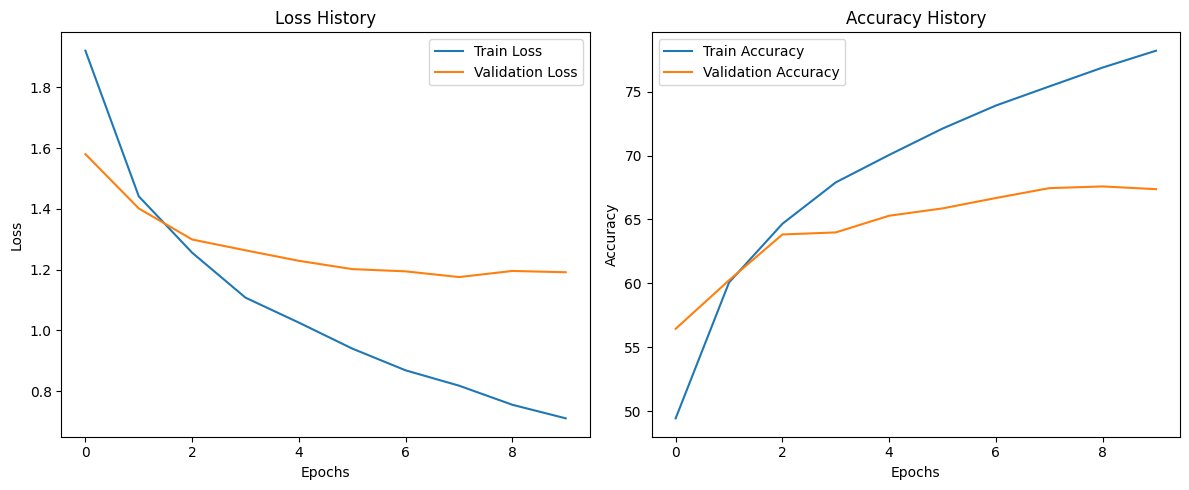

Evaluating: 100%|██████████| 118/118 [01:01<00:00,  1.90it/s]


 Test Loss: 1.1913 | Test Accuracy: 67.37%


In [21]:
plot_history(history)
test_loss, test_accuracy = evaluate(final_model, test_dataloader, all_text_inputs, loss_fn, device)
print('\n',f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")